# Úkol č. 2 - předzpracování dat a binární klasifikace (do 2. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

# Solution:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
import sklearn.metrics as metrics

Firstly, I decided to define some constants to use later in the code and have it all in one place:

In [2]:
TEST_SPLIT_SIZE = .2
VAL_SPLIT_SIZE = .2

RANDOM_SEED = 123

KFOLD_SPLITS = 10

accuracy_scores = pd.Series(dtype=float)

Then I defined two functions that helped me to prepare the dataset for the classification process. `categorize_columns` function helped me to convert the `object` columns into `category` ones, so that `scikit-learn` classificators could work with that data. `fill_missing` function is determined to fill the `NaN` values in the resulted categorized DataFrame. Here, I fill the missing values with the mean value of that column.

In [3]:
def categorize_columns(data):
    object_columns = data.select_dtypes(['object']).columns
    data[object_columns] = data[object_columns].astype('category').apply(lambda x: x.cat.codes)
    
def fill_missing(data):
    missing_columns = data.loc[:, data.isna().sum() > 0].columns.to_list()
    data[missing_columns] = data[missing_columns].fillna(data[missing_columns].mean(skipna=True))

Next, I read the dataset from the given `.csv` file, got the columns I needed and used the function defined above to prepare it for the classification process. The chosen columns are:

* *ID* ... as I needed to identify the Titanic passengers later;
* *pclass* ... as I thought that this is a good parameter to determine the survival rate (passengers with higher class had more priority to be saved);
* *sex* ... as I wanted to see if both genders had the same survival rate;
* *age* ... as I thought that younger people had more chances to survive;
* *fare* ... similar to pclass.

In my opinion, the other columns were not so much useful to determine the survival rate. There is not much information about it in a passenger's *name*, *number of siblings or spouses*, *number of parents or children*, *cabin*, etc.

In the *mean* table below we can see the mean values of chosen columns grouped by *pclass*. It can be seen pretty clearly that the first class passengers were older, paid more for the ticket and had greater survival rate.

In [4]:
df = pd.read_csv("data.csv")

display("Original DataFrame:", df)

X_columns = ['ID', 'pclass', 'sex', 'age', 'fare']
y_columns = ['survived']
data = df[X_columns + y_columns].copy()

categorize_columns(data)
fill_missing(data)

display("Processed DataFrame:", data)
display("Mean values by pclass:", data.groupby(by='pclass').mean())

'Original DataFrame:'

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
1,1,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S,NaN
2,2,0,3,"Hegarty, Miss. Hanora ""Nora""",female,18.0,0,0,365226,6.7500,NaN,Q,NaN
3,3,0,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.5500,NaN,S,NaN
4,4,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0,3,"Sdycoff, Mr. Todor",male,NaN,0,0,349222,7.8958,NaN,S,NaN
996,996,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S,"Italy Philadelphia, PA"
997,997,0,3,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",female,28.0,1,1,347080,14.4000,NaN,S,"Stanton, IA"
998,998,0,3,"Sivic, Mr. Husein",male,40.0,0,0,349251,7.8958,NaN,S,NaN


'Processed DataFrame:'

,ID,pclass,sex,age,fare,survived
0,0,3,1,19.000000,8.0500,1
1,1,2,0,40.000000,13.0000,1
2,2,3,0,18.000000,6.7500,0
3,3,3,1,29.342535,69.5500,0
4,4,3,0,30.000000,8.6625,0
...,...,...,...,...,...,...
995,995,3,1,29.342535,7.8958,0
996,996,3,1,29.342535,7.0500,1
997,997,3,0,28.000000,14.4000,0
998,998,3,1,40.000000,7.8958,0


'Mean values by pclass:'

,ID,sex,age,fare,survived
pclass,,,,,
1,511.594142,0.531381,37.859090,89.860025,0.635983
2,488.280952,0.604762,28.617502,21.452678,0.447619
3,498.529946,0.698730,25.924749,13.355482,0.266788


Next, I divided the dataset into three parts - **train**, **val** and **test**. These parts were then used to determine the `accuracy_score` of the models and to find the best one.

In [5]:
X_data = data.drop(columns=['survived'])
y_data = data.survived

X_train_val, X_test, y_train_val, y_test = \
    train_test_split(X_data, y_data, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = \
    train_test_split(X_train_val, y_train_val, test_size=VAL_SPLIT_SIZE, random_state=RANDOM_SEED)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(640, 5) (160, 5) (200, 5) (640,) (160,) (200,)


These next two functions provided me with the possibility to choose a method of searching the best hyperparameters for the models. The `find_best_hyperparams` function uses simple iteration to find hyperparameters for the model that resulted in the best validation data accuracy score.

In [6]:
def find_best_hyperparams(model_class, param_grid, **model_params):
    param_comb = ParameterGrid(param_grid)
    
    val_acc = [metrics.accuracy_score(y_val, 
                                      model_class(**params, **model_params)
                                                  .fit(X_train, y_train)
                                                  .predict(X_val))
               for params in param_comb]

    return param_comb[np.argmax(val_acc)]

The `cross_validation` function uses the **cross validation** algorithm to find these hyperparameters. The dataset used there is a concatenation of the *train* and *val* data as this method does not need static validation data, but iterates through the parts of the given dataset and finds mean errors for every dynamic part.

In [7]:
def cross_validation(model_class, param_grid, **model_params):
    param_comb = ParameterGrid(param_grid)
    err = []
    train_val = pd.concat([X_train_val, y_train_val], axis=1)
    
    for grid_params in param_comb:
        comb_err = []
        for train, val in KFold(n_splits=KFOLD_SPLITS,
                                random_state=RANDOM_SEED,
                                shuffle=True).split(train_val):
            
            X_train_cv = X_train_val[X_train_val.index.isin(train)]
            y_train_cv = y_train_val[y_train_val.index.isin(train)]
            X_val_cv = X_train_val[X_train_val.index.isin(val)]
            y_val_cv = y_train_val[y_train_val.index.isin(val)]

            model = model_class(**grid_params, **model_params)
            model.fit(X_train_cv, y_train_cv)
            comb_err.append(np.sqrt(metrics.mean_squared_error(y_val_cv, model.predict(X_val_cv))))

        err.append(np.mean(comb_err))
        
    return param_comb[np.argmin(err)]

## Decision tree:

Finally, after a lot of preparations, we can start to build the prediction models. Here is the first one - **desicion tree**. I used a `DecisionTreeClassifier` class from the `scikit-learn` library and tried to use both iteration or cross validation to find the best hyperparameters. You can see the accuracy scores on all three parts of the data below.

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

param_grid = {
    'max_depth': range(1, 11), 
    'criterion': ['entropy', 'gini']
}

# best_params_iter= find_best_hyperparams(DecisionTreeClassifier, param_grid, random_state=RANDOM_SEED)
best_params_cv = cross_validation(DecisionTreeClassifier, param_grid, random_state=RANDOM_SEED)

dt = DecisionTreeClassifier(random_state=RANDOM_SEED, **best_params_cv).fit(X_train, y_train)

train_accuracy_score = metrics.accuracy_score(y_train, dt.predict(X_train))
val_accuracy_score = metrics.accuracy_score(y_val, dt.predict(X_val))
test_accuracy_score = metrics.accuracy_score(y_test, dt.predict(X_test))
accuracy_scores["dt"] = test_accuracy_score

print(f"Best params: {best_params_cv}")
print("Accuracy (train): {0:.6f}".format(train_accuracy_score))
print("Accuracy (val): {0:.6f}".format(val_accuracy_score))
print("Accuracy (test): {0:.6f}".format(test_accuracy_score))

Best params: {'max_depth': 3, 'criterion': 'gini'}
Accuracy (train): 0.795312
Accuracy (val): 0.818750
Accuracy (test): 0.830000


I was also happy to know that it is easy to draw desicion trees using `scikit-learn` library. Here is the plot of the tree trained above:

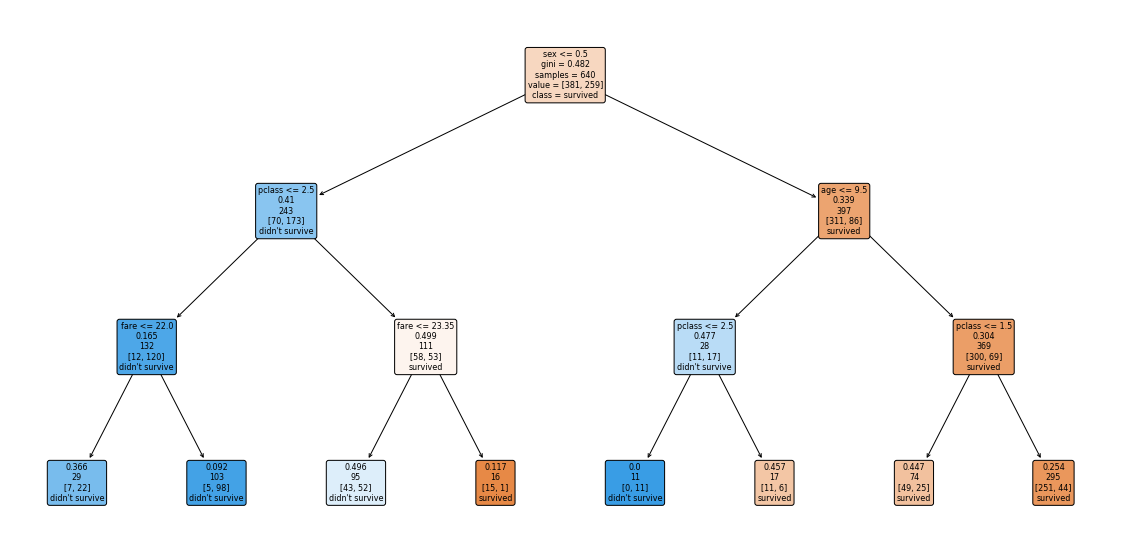

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt,
          filled=True,
          feature_names=X_data.columns,
          class_names=["survived", "didn't survive"],
          rounded=True,
          fontsize=10,
          label='root')
plt.show()

## Random forest:

The next model I chose to train was random forest. `scikit-learn` provides us with the `RandomForestClassifier` class, so I used it. The process of training is pretty much the same here, as is in the **Decision tree** part above and **AdaBoost** and **k-nearest Neighbors** below.

In [10]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': range(1, 10), 
    'criterion': ['entropy', 'gini'],
    'n_estimators': range(30, 61, 5)
}

# best_params_iter = find_best_hyperparams(RandomForestClassifier, param_grid, random_state=RANDOM_SEED)
best_params_cv = cross_validation(RandomForestClassifier, param_grid, random_state=RANDOM_SEED)

rf = RandomForestClassifier(random_state=RANDOM_SEED, **best_params_cv).fit(X_train, y_train)

train_accuracy_score = metrics.accuracy_score(y_train, rf.predict(X_train))
val_accuracy_score = metrics.accuracy_score(y_val, rf.predict(X_val))
test_accuracy_score = metrics.accuracy_score(y_test, rf.predict(X_test))
accuracy_scores["rf"] = test_accuracy_score

print(f"Best params: {best_params_cv}")
print("Accuracy (train): {0:.6f}".format(train_accuracy_score))
print("Accuracy (val): {0:.6f}".format(val_accuracy_score))
print("Accuracy (test): {0:.6f}".format(test_accuracy_score))

Best params: {'n_estimators': 35, 'max_depth': 7, 'criterion': 'gini'}
Accuracy (train): 0.885938
Accuracy (val): 0.800000
Accuracy (test): 0.825000


## AdaBoost:

Same here: `AdaBoostClassifier` class from the `scikit-learn` library.

In [11]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': range(1, 82, 10),
    'base_estimator': [DecisionTreeClassifier(max_depth=x) for x in range(1, 7)]
}

# best_params_iter = find_best_hyperparams(AdaBoostClassifier, param_grid, random_state=RANDOM_SEED)
best_params_cv = cross_validation(AdaBoostClassifier, param_grid, random_state=RANDOM_SEED)

ab = AdaBoostClassifier(random_state=RANDOM_SEED, **best_params_cv).fit(X_train, y_train)

train_accuracy_score = metrics.accuracy_score(y_train, ab.predict(X_train))
val_accuracy_score = metrics.accuracy_score(y_val, ab.predict(X_val))
test_accuracy_score = metrics.accuracy_score(y_test, ab.predict(X_test))
accuracy_scores["ab"] = test_accuracy_score

print(f"Best params: {best_params_cv}")
print("Accuracy (train): {0:.6f}".format(train_accuracy_score))
print("Accuracy (val): {0:.6f}".format(val_accuracy_score))
print("Accuracy (test): {0:.6f}".format(test_accuracy_score))

Best params: {'n_estimators': 1, 'base_estimator': DecisionTreeClassifier(max_depth=3), 'algorithm': 'SAMME'}
Accuracy (train): 0.795312
Accuracy (val): 0.818750
Accuracy (test): 0.830000


## k-nearest Neighbors:

This algorithm was the most interesting for me, as for my data it had the lowest accuracy scores for all three parts. Neither iterative method of searching nor cross validation helped me to raise these scores, so I decided to scale the data, and it helped a little:

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors' : range(1, 25),
    'p': range(1, 3),
    'weights': ['uniform', 'distance']
}

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# best_params_iter = find_best_hyperparams(KNeighborsClassifier, param_grid)
best_params_cv = cross_validation(KNeighborsClassifier, param_grid)

kn = KNeighborsClassifier(**best_params_cv).fit(X_train_scaled, y_train)

train_accuracy_score = metrics.accuracy_score(y_train, kn.predict(X_train_scaled))
val_accuracy_score = metrics.accuracy_score(y_val, kn.predict(X_val_scaled))
test_accuracy_score = metrics.accuracy_score(y_test, kn.predict(X_test_scaled))
accuracy_scores["kn"] = test_accuracy_score

print(f"Best params: {best_params_cv}")
print("Accuracy (train): {0:.6f}".format(train_accuracy_score))
print("Accuracy (val): {0:.6f}".format(val_accuracy_score))
print("Accuracy (test): {0:.6f}".format(test_accuracy_score))

Best params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 22}
Accuracy (train): 0.773438
Accuracy (val): 0.787500
Accuracy (test): 0.800000


## Final evaluation:

To create the `results.csv` file I needed to load the given `evaluation.csv` dataset and predict the survival values for it. Here I cleaned it and created the `predict_df` DataFrame with the predictions of all models trained above.

In [13]:
eval_df = pd.read_csv("evaluation.csv")

display("Original evaluation DataFrame:", eval_df)

eval_data = eval_df[X_columns].copy()
categorize_columns(eval_data)
fill_missing(eval_data)

display("Processed evaluation DataFrame:", eval_data)

predict_df = pd.DataFrame(eval_data["ID"])
predict_df["dt"] = pd.Series(dt.predict(eval_data), index=eval_data.index)
predict_df["rf"] = pd.Series(rf.predict(eval_data), index=eval_data.index)
predict_df["ab"] = pd.Series(ab.predict(eval_data), index=eval_data.index)
predict_df["kn"] = pd.Series(kn.predict(eval_data), index=eval_data.index)

'Original evaluation DataFrame:'

,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1000,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27.0000,NaN,S,London
1,1001,2,"Christy, Miss. Julie Rachel",female,25.0,1,1,237789,30.0000,NaN,S,London
2,1002,2,"Gale, Mr. Harry",male,38.0,1,0,28664,21.0000,NaN,S,"Cornwall / Clear Creek, CO"
3,1003,3,"McNamee, Mrs. Neal (Eileen O'Leary)",female,19.0,1,0,376566,16.1000,NaN,S,NaN
4,1004,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,NaN,S,"Swindon, England"
...,...,...,...,...,...,...,...,...,...,...,...,...
304,1304,3,"Buckley, Miss. Katherine",female,18.5,0,0,329944,7.2833,NaN,Q,"Co Cork, Ireland Roxbury, MA"
305,1305,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,"Hong Kong New York, NY"
306,1306,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.2250,NaN,C,NaN
307,1307,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S,"Youngstown, OH"


'Processed evaluation DataFrame:'

,ID,pclass,sex,age,fare
0,1000,2,0,24.0,27.0000
1,1001,2,0,25.0,30.0000
2,1002,2,1,38.0,21.0000
3,1003,3,0,19.0,16.1000
4,1004,2,0,60.0,26.0000
...,...,...,...,...,...
304,1304,3,0,18.5,7.2833
305,1305,3,1,32.0,56.4958
306,1306,3,1,22.5,7.2250
307,1307,1,0,45.0,164.8667


Here we can see, that all models had nearly the same accuracy scores on the testing data that they never saw.

In [14]:
display(accuracy_scores)

dt    0.830
rf    0.825
ab    0.830
kn    0.800
dtype: float64

So, having that I decided to combine the results and compute the predictions for Titanic passergers based on all models. If more than two models had the same prediction, I used it as the result. Otherwise, if two models took one side and two the other, I chose the prediction of the model with the greatest `accuracy_score`.

In [15]:
def final_prediction(series):
    vc = series.value_counts()
    if vc.iloc[0] > 2:
        return vc.idxmax()
    else:
        return series[accuracy_scores.idxmax()]

Here is complete `predict_df` DataFrame with the predictions of all models and final prediction determined by the method described above.

In [16]:
predict_df["survived"] = predict_df.apply(final_prediction, axis=1)
display("Predicted values:", predict_df)
display("Percentage of the survivors:", predict_df.iloc[:, 1:].mean())

'Predicted values:'

,ID,dt,rf,ab,kn,survived
0,1000,1,1,1,1,1
1,1001,1,1,1,1,1
2,1002,0,0,0,1,0
3,1003,1,0,1,1,1
4,1004,1,1,1,0,1
...,...,...,...,...,...,...
304,1304,1,1,1,1,1
305,1305,0,1,0,1,0
306,1306,0,0,0,1,0
307,1307,1,1,1,1,1


'Percentage of the survivors:'

dt          0.317152
rf          0.401294
ab          0.317152
kn          0.838188
survived    0.317152
dtype: float64

The only thing left to consider was to write the results to the file `results.csv`. After that, the solution is complete.

In [17]:
display(predict_df[["ID", "survived"]])
predict_df[["ID", "survived"]].to_csv("results.csv", index=False)

,ID,survived
0,1000,1
1,1001,1
2,1002,0
3,1003,1
4,1004,1
...,...,...
304,1304,1
305,1305,0
306,1306,0
307,1307,1
